In [1]:
import os.path, gym
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import roboschool
import pdb
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
GAMMA = .97
from functools import partial
NUM_HISTORY = N_HISTORY = 6
try:
    env.close()
except:
    pass
if 1:
    envname = "RoboschoolInvertedPendulum-v1"
    SIZE_MULT = 2
    REWARD_MULT = 1
    RANDOM_STYLE_COMPLEX = 0
    N_LAYERS = 16
    N_DROP = 5
else:
    envname = "RoboschoolHumanoidFlagrun-v1"
    SIZE_MULT = 8
    REWARD_MULT = 4
    RANDOM_STYLE_COMPLEX = 1
    N_LAYERS = 20
    N_DROP = 5
INIT_LEN = 600
N_PRETRAIN = 300
NUM_KEEP = 1000
PERCENT_CHOOSE_OPTIMAL = 2
env = gym.make(envname)
N_OBS, N_ACT = [v.shape[0] for v in [env.observation_space, env.action_space]]
N_STATE = (N_OBS + N_ACT) * 2
REWARD_IN_STATE = 0
if REWARD_IN_STATE:
    N_STATE += 2
INPUT_UNITS = N_STATE * NUM_HISTORY
STATE_DECAY = .8
TESTING_GRAD_NORMS = 1
ADV_ENABLED = 0
STORED_MODELS = {}
FCNS = {'np':{
    'concat':np.concatenate,
    'reshape':np.reshape,
    'expand':np.expand_dims
},'tf':{
    'concat':tf.concat,
    'reshape':tf.reshape,
    'expand':tf.expand_dims
}}

/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


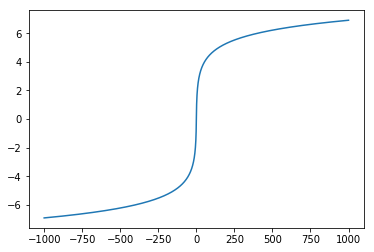

In [2]:
x = np.arange(-1000, 1000, .01)

y = np.log(np.abs(x)+1) * np.sign(x)

plt.plot(x, y)

In [3]:

def apply_clipped_optimizer(opt_fcn,
                            loss,
                            clip_norm=.1,
                            clip_single=.03,
                            clip_global_norm=False,
                            var_list=None):
    if var_list is None:
        gvs = opt_fcn.compute_gradients(loss)
    else:
        gvs = opt_fcn.compute_gradients(loss, var_list = var_list)
        

    if clip_global_norm:
        gs, vs = zip(*[(g, v) for g, v in gvs if g is not None])
        capped_gs, grad_norm_total = tf.clip_by_global_norm([g for g in gs],clip_norm)
        capped_gvs = list(zip(capped_gs, vs))
    else:
        grad_norm_total = tf.sqrt(
                tf.reduce_sum([
                        tf.reduce_sum(tf.square(grad)) for grad, var in gvs
                        if grad is not None
                ]))
        capped_gvs = [(tf.clip_by_value(grad, -1 * clip_single, clip_single), var)
                                    for grad, var in gvs if grad is not None]
        capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var)
                                    for grad, var in capped_gvs if grad is not None]

    optimizer = opt_fcn.apply_gradients(capped_gvs)

    return optimizer, grad_norm_total

class MLP:
    def __init__(self,
                x, lshapes, output_units, namebase, squeeze = True,
                lshapes_drop = None, drop_rate = .2, reuse = False):
        self.namebase = namebase
        self.reuse = reuse
        self.lidx = 0
        name_fcn = self.get_name
        h = [tf.nn.leaky_relu(tf.layers.dense(
            x, lshapes[0], name=self.get_name(), reuse = self.reuse))]
        h2 = h[-1]
        for size in lshapes:
            h.append(tf.nn.leaky_relu(h[-1] + tf.layers.dense(
                h2, size, name=name_fcn(), reuse = self.reuse)))
            h2 = tf.concat((x, h[-1]), -1)
        if lshapes_drop is None:
            hout = tf.concat((h[len(h)//2:]), -1)
            output = tf.layers.dense(
                hout, output_units, name=name_fcn(), reuse = self.reuse)
            if output_units == 1 and squeeze:
                output = tf.squeeze(output, -1)
            self.raw_output = output
            self.output = leaky_tanh(self.raw_output)
        else:
            drop_outs = []
            x_drop = tf.concat((h[len(h)//2:]), -1)
            name_fcn = self.get_name_drop
            self.lidx_drop = 0
            for drop_idx, drop_try in enumerate(lshapes_drop):
                h_drop = [x_drop]
                for lsize in lshapes_drop:
                    new_layer = tf.nn.dropout(tf.nn.leaky_relu(tf.layers.dense(
                        h_drop[-1], size, name=name_fcn(), reuse = self.reuse)), keep_prob = 1-drop_rate)
                    h_drop.append(new_layer)
                output = tf.layers.dense(h_drop[-1], output_units)
                if output_units == 1 and squeeze:
                    output = tf.squeeze(output, -1)
                output = leaky_tanh(output)
                drop_outs.append(output)
                self.reuse = True
                self.lidx_drop = 0
            self.output = tf.stack(drop_outs, -1)
            self.output_mean, self.variance = tf.nn.moments(self.output, -1)
    def get_name(self):
        self.lidx = self.lidx + 1
        return self.namebase + str(self.lidx)
    def get_name_drop(self):
        self.lidx_drop = self.lidx_drop + 1
        return self.namebase + '_drop_' + str(self.lidx_drop)

In [4]:


def make_state(state, action, style = 'np'):
    together = FCNS[style]['concat']((state, action), -1)
    if style == 'tf':
        return together
#         expanded = FCNS[style]['expand'](
#             together, 1)
    else:
        expanded = FCNS[style]['expand'](
            together, 0)
    return expanded
    return FCNS[style]['reshape'](
        together, (state.shape[0], -1, state.shape[-1] + action.shape[-1]))
        
    

def accumulate_state(state, action, old_state, statedecay, style = 'np'):
    new_state = make_state(state, action, style)
    new_state_len = new_state.shape[-1]
    if style == 'tf':
        vel = new_state - old_state[:,:,0,:new_state_len]
    else:
        vel = new_state - old_state[0,:new_state_len]
    new_state = FCNS[style]['concat']((new_state, vel), -1)
    if style == 'tf':
        return FCNS[style]['concat']((tf.expand_dims(new_state, 2), old_state[:,:,:-1,:]*statedecay), 2)
    return FCNS[style]['concat']((new_state, old_state[:-1,:]*statedecay), 0)

def leaky_tanh(x):
    return tf.log(tf.abs(x)+1) * tf.sign(x)/2
    #return tf.nn.tanh(x*30)/10 + tf.nn.tanh(x*2)/2 + tf.nn.tanh(x/20) * 2 + x * 1e-3

In [5]:


class PolicyLearner(object):
    def __init__(self, ob_space, ac_space, take_weights_here=None, 
                 lshapes = [64 * SIZE_MULT] * N_LAYERS, config = None, 
                 lshapes_small = [32 * SIZE_MULT] * N_LAYERS,
                 lshapes_smaller = [32 * SIZE_MULT] * N_LAYERS,
                 lshapes_drop = [32 * SIZE_MULT] * N_DROP,
                reuse = False):
        self.sess = tf.InteractiveSession(config=config)
        self.obs_raw = tf.placeholder(tf.float32, (None, None, NUM_HISTORY, N_STATE))
        self.returns = tf.placeholder(tf.float32, (None, None))
        self.returnsdecayed = tf.placeholder(tf.float32, (None, None))
        self.mask = tf.placeholder(tf.float32, (None, None))
        self.lr = tf.placeholder_with_default(1e-3, (None))
        self.statesraw = tf.placeholder(tf.float32, (None, None, N_OBS))
        self.is_train = tf.placeholder_with_default(True, (None))
        self.is_exploit = tf.placeholder(tf.float32, (None))
        self.is_exploit2d = tf.expand_dims(self.is_exploit, -1)
        self.is_exploit3d = tf.expand_dims(self.is_exploit2d, -1)
        self.statesraw_expanded = tf.expand_dims(self.statesraw, -1)
        self.obs_raw_expanded = tf.expand_dims(self.obs_raw, -1)
        self.obs = tf.reshape(
            self.obs_raw, (
                tf.shape(self.obs_raw)[0], tf.shape(self.obs_raw)[1], N_STATE * NUM_HISTORY))
        self.actor = MLP(
            self.obs, lshapes, N_ACT, 'a_', squeeze = False, reuse = reuse)
        self.actions = self.actor.output
        self.state_value_estimator = MLP(
            self.obs, lshapes_smaller, 1, 'v_', reuse = reuse)
        self.state_value_estimate = self.state_value_estimator.output
        
        self.advantage = ((
            self.state_value_estimate[:,1:] * GAMMA + self.returns[:,:-1]) -
            self.state_value_estimate[:,:-1])
        
        self.critic_input = tf.concat((self.obs, self.actions), -1)
        
        self.advantage_estimator = MLP(
            self.critic_input, lshapes_small, 1, 'c_', lshapes_drop = lshapes_drop, reuse = reuse)
        self.advantage_estimate = self.advantage_estimator.output_mean
        self.model_estimator = MLP(
            self.critic_input, lshapes, N_OBS, 'm_', lshapes_drop = lshapes_drop, reuse = reuse)
        self.model_estimate = self.model_estimator.output_mean
        self.future_obs_raw = accumulate_state(
            self.model_estimate, self.actions, self.obs_raw, STATE_DECAY, style = 'tf')
        
        self.future_obs = tf.reshape(self.future_obs_raw, 
            (tf.shape(self.future_obs_raw)[0],tf.shape(self.future_obs_raw)[1], N_STATE * NUM_HISTORY))
        
        self.future_value = MLP(
            self.future_obs, lshapes_smaller, 1, 'v_', reuse = True)
        

        self.future_actor = MLP(
            self.future_obs, lshapes, N_ACT, 'a_', reuse = True, squeeze = False)
        self.future_actions = self.future_actor.output
        
        self.future_critic_input = tf.concat((self.future_obs, self.future_actions), -1)
        self.future_advantage_estimator = MLP(
            self.future_critic_input, lshapes_small, 1, 'c_', lshapes_drop = lshapes_drop, reuse = True)
        
        if len(self.future_actions.shape) == 2:
            self.future_actions = tf.expand_dims(self.future_actions, -1)
        
        self.t_vars = tf.trainable_variables()
        self.a_vars = [var for var in self.t_vars if 'a_' in var.name]
        self.v_vars = [var for var in self.t_vars if 'v_' in var.name]
        self.c_vars = [var for var in self.t_vars if 'c_' in var.name]
        self.m_vars = [var for var in self.t_vars if 'm_' in var.name]
        
        self.creg, self.areg, self.vreg, self.mreg = [
            tf.reduce_mean([tf.reduce_mean(tf.square(v)) for v in optvars]) * 1e0
            for optvars in 
            [self.c_vars, self.a_vars, self.v_vars, self.m_vars]]
        self.maskexpanded = tf.expand_dims(self.mask, -1)
        self.maskexpanded2 = tf.expand_dims(self.maskexpanded, -1)
        
        self.model_state_estimate = self.model_estimator.output_mean
        
        self.v_loss_raw = tf.reduce_mean(tf.square(
            self.returnsdecayed - self.state_value_estimate) * self.mask * self.is_exploit2d) * 3
        self.v_loss =  self.v_loss_raw + self.vreg
        
        self.m_loss_raw = tf.reduce_mean(tf.square(
            self.model_estimator.output[:,:-1] - self.statesraw_expanded[:,1:]
        ) * self.maskexpanded2[:,:-1]) * 10000
        self.m_loss = self.m_loss_raw + self.mreg
        
        self.c_loss_raw = tf.reduce_mean(tf.square(
            self.advantage_estimate[:,:-1] - self.advantage) * self.mask[:,:-1]) * 3
        self.c_loss =  self.c_loss_raw + self.creg
        
        
        self.actionmean = tf.reduce_sum(
            self.actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1) + tf.reduce_sum(
            self.future_actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1) 
        
        
        self.actionmean = tf.reduce_sum(
            self.actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1)
        self.actdiffsquared = tf.square(
            self.actions - tf.expand_dims(self.actionmean, 1))
        self.actvar = tf.reduce_sum(
            self.actdiffsquared * self.maskexpanded, 1)/ tf.reduce_sum(
            self.maskexpanded, 1)
        self.actstd = self.actvar
        self.actstdpenalty = -tf.reduce_mean(tf.log(self.actstd + .00001)* .0001 + tf.square(self.actstd)) * .001
        
        self.aregmeanbyaction = tf.reduce_mean(
            tf.square(self.actionmean)) * .01
        self.a_mse = tf.reduce_mean(tf.square(
            self.actions + self.future_actions) * self.maskexpanded) * 1e-2 + tf.reduce_mean(
            tf.square(self.actor.raw_output + self.future_actor.raw_output) * self.maskexpanded) * 3e1
        self.aregtotal = self.areg + self.aregmeanbyaction + self.actstdpenalty + self.a_mse
        
        self.frac_not_masked = tf.reduce_mean(self.mask)
        
        self.a_loss_critic = -tf.reduce_mean(
            self.advantage_estimator.output_mean * self.mask)/self.frac_not_masked * 200
        self.a_loss_model = -tf.reduce_mean(
            self.future_value.output * self.mask)/self.frac_not_masked * 10
        self.a_loss_secondaction = -tf.reduce_mean(
            self.future_advantage_estimator.output_mean * self.mask)/self.frac_not_masked * 100
        self.a_loss_raw = self.a_loss_critic + self.a_loss_model + \
            self.a_loss_secondaction
        
        self.a_loss = self.a_loss_raw + self.aregtotal
        
        self.grad_v = tf.square(tf.gradients(
            self.state_value_estimator.output * self.mask, self.obs)[0])
        self.grad_m = tf.square(tf.gradients(
            self.model_estimator.output * self.maskexpanded2, self.critic_input)[0])
        self.grad_c = tf.square(tf.gradients(
            self.advantage_estimator.output * self.maskexpanded, self.critic_input)[0])
        
        self.grad_norm_m = tf.reduce_mean(self.grad_m) * 1e-2
        self.grad_norm_v = tf.reduce_mean(self.grad_v) * 1e-4
        self.grad_norm_c = tf.reduce_mean(self.grad_c) * 1e-1
    
        slopes = tf.reduce_sum(tf.square(self.grad_c), reduction_indices=[2])
        self.grad_c_1 = tf.reduce_mean(self.mask * (slopes - .2) ** 2) * 1e-1
        slopes = tf.reduce_sum(tf.square(self.grad_m), reduction_indices=[2])
        self.grad_m_1 = tf.reduce_mean(self.mask * (slopes - .2) ** 2) * 1e-5
       
        self.a_loss_minimize = self.a_loss
        self.c_loss_minimize = self.c_loss + self.grad_norm_c + self.grad_c_1
        self.v_loss_minimize = self.v_loss + self.grad_norm_v
        self.m_loss_minimize = self.m_loss + self.grad_norm_m + self.grad_m_1
        
        self.critic_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.value_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.actor_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.model_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        
        def get_grad_norm(optimizer, loss):
            gvs = optimizer.compute_gradients(loss)
            grad_norm = tf.reduce_mean(
                [tf.reduce_mean(tf.square(grad)) for
                 grad, var in gvs if grad is not None])
            return grad_norm
        
        if TESTING_GRAD_NORMS:
            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.a_loss_critic,self.a_loss_model,
                self.a_loss_secondaction,
                self.areg, self.aregmeanbyaction, self.actstdpenalty, self.a_mse
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.creg, self.grad_norm_c, self.grad_c_1

            ]]
            self.m_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.m_loss_minimize, self.m_loss_raw, 
                self.mreg, self.grad_norm_m, self.grad_m_1
            ]]
        
        self.copt, self.c_norm = apply_clipped_optimizer(
            self.critic_opt, self.c_loss_minimize, var_list = self.c_vars)
        self.vopt, self.v_norm = apply_clipped_optimizer(
            self.value_opt, self.v_loss_minimize, var_list = self.v_vars)
        self.aopt, self.a_norm = apply_clipped_optimizer(
            self.actor_opt, self.a_loss_minimize, var_list = self.a_vars)
        self.mopt, self.m_norm = apply_clipped_optimizer(
            self.model_opt, self.m_loss_minimize, var_list = self.m_vars)

    def a_name(self):
        self.a_idx += 1
        return 'a_' + str(self.a_idx)
    def c_name(self):
        self.c_idx += 1
        return 'c_' + str(self.c_idx)
    def v_name(self):
        self.v_idx += 1
        return 'v_' + str(self.v_idx)
    def m_name(self):
        self.m_idx += 1
        return 'm_' + str(self.m_idx)
    
    def load_weights(self):
        feed_dict = {}
        for (var, w), ph in zip(
            self.assigns, self.weight_assignment_placeholders):
            feed_dict[ph] = w
        self.sess.run(self.weight_assignment_nodes, feed_dict=feed_dict)

    def act(self, obs):
        # Because we need batch dimension, 
        # data[None] changes shape from [A] to [1,A]
        a = self.sess.run(
            self.actions, feed_dict={
                self.obs_raw:np.reshape(obs, (1, 1, N_HISTORY, N_STATE)),
                self.is_train:False
            })
        return a[0][0]  # return first in batch



config = tf.ConfigProto(
    inter_op_parallelism_threads=0,
    intra_op_parallelism_threads=0,
    device_count = { "GPU": 0 } )
tf.reset_default_graph()

pi = PolicyLearner(env.observation_space, env.action_space, config = config)

sess = pi.sess
self = pi
sess.run(tf.global_variables_initializer())
#trainer = ZooPolicyTensorflow(
# "mymodel1", env.observation_space, env.action_space)
saver = tf.train.Saver()

In [6]:
# env.close()


# env = gym.make(envname)

In [7]:

#         self.advantage = ((
#             self.stateraw_value_estimate[:,1:] * GAMMA + self.returns) -
#             self.state_value_estimate[:,:-1])

In [8]:

ah, sh, shraw, rh, rdecayedh, maskh = [
    np.zeros((0, 0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
isexploit = []
globalframes = []
localframes = []
ep = 0
trained = 0
ongoing = 0
printfreq = 10
obj_fname = envname + str(PERCENT_CHOOSE_OPTIMAL) + 'saveobjs_unguided.pkl'
tffile = "tmp/" + envname + str(PERCENT_CHOOSE_OPTIMAL) + "unguided_trained.ckpt"
import pickle

In [9]:
ongoing = 0
sess.run(tf.global_variables_initializer())

In [10]:
if ongoing:
    
    save_path = saver.save(sess, tffile)
    print('saved at epoch', ep)
    with open(obj_fname,"wb") as f:
        pickle.dump(
            [ah, sh, rh, rdecayedh, maskh, ep, globalframes, isexploit
            ], f)
    trained = 1

In [11]:
trained = 0

In [12]:

def train_actor(self, feed_dict, printon):
    _, aloss = sess.run(
        [self.aopt, self.a_loss],
        feed_dict = feed_dict
            )
    if TESTING_GRAD_NORMS and ep % printfreq == 0 and printon:
        a_grad_norms = self.sess.run(self.a_grads, feed_dict)
        print('a grad norms', a_grad_norms)
    else:
        a_grad_norms = 0
    return aloss, a_grad_norms

In [13]:
def train(actor = True, value = True, n_steps = 1, forced_hist = 2):
    for itr in range(n_steps):
        if num_hist >  batch_size:
            #probability = np.arange(num_hist - forced_hist)
            probability = num_steps_per_run = (
                maskh.shape[1] - maskh[:,::-1].argmax(1))
            if forced_hist:
                probability = probability[:-forced_hist]
            probability = np.square(probability)
            probability = probability / probability.sum()
            rnd = np.random.choice(
                    num_hist - forced_hist, batch_size - forced_hist, 
                    replace=False, p=probability)
            if forced_hist:
                samples = np.concatenate((rnd,
                    np.arange( num_hist - forced_hist, num_hist)))
            else:
                samples=rnd
        else:
            samples = np.random.choice(num_hist, num_hist, replace=False)
        actions, states, statesraw, returns, returnsdecayed, mask, exploit = [
            v[samples] for v in [ah, sh, shraw, rh,rdecayedh, maskh, np.array(isexploit)]]
        feed_dict={
                    self.returns:returns,
                    self.statesraw: statesraw,
                    self.returnsdecayed:returnsdecayed,
                    self.lr: .01 / np.power(ep + 20, .4),
                    self.mask:mask,
                    self.obs_raw: states.reshape(*states.shape[:2], N_HISTORY, N_STATE),
                    self.is_exploit:exploit
        }
        if actor:
            aloss, a_grad_norms = train_actor(self, feed_dict, printon = itr == 0)
        else:
            aloss = 0
        feed_dict[self.actions] = actions
        if value:
            if exploit.sum() > 0:
                _,_, _, mloss, closs, vloss = sess.run(
                    [self.mopt, self.copt,self.vopt, self.m_loss, self.c_loss, self.v_loss],
                        feed_dict=feed_dict)
            else:
                _, mloss = sess.run(
                    [self.mopt, self.m_loss],
                        feed_dict=feed_dict)
                closs = vloss = 0
        else:
            mloss = closs =  vloss = 0
    if 1:
        if ep % printfreq == 0:
            print('aloss', aloss, 'closs', closs, 'vloss', vloss)
            if TESTING_GRAD_NORMS:
                v_grad_norms, c_grad_norms, m_grad_norms = self.sess.run(
                    [self.v_grads, self.c_grads, self.m_grads], feed_dict)
                print('v grad norms', v_grad_norms)
                print('c grad norms', c_grad_norms)
                print('m grad norms', m_grad_norms)
    if ep % printfreq == 0:
        print(' ep, ', ep, ' avg frames',np.mean(globalframes[-20:]))
        print('abs action',np.abs(ah)[-1,0,:].shape, np.abs(ah)[-1,0,:].mean())
        print('max reward',np.max(rh[-10:,10:]))
    if ep % 10000 == 0:
        clear_output()
    if ep % 100 == 0:
        ysmoothed = gaussian_filter1d(globalframes, sigma=4)
        plt.plot(ysmoothed)
        plt.show()

score 96.0  frames 48
saved at epoch 100
saved at epoch 200
saved at epoch 300
saved at epoch 400
saved at epoch 500
saved at epoch 600
a grad norms [609.78937, 16.641163, 19.83131, 0.56606215, 9.071911, 9.549169e-12, 3.3354812e-07, 1.8585473e-11, 1267.7533]
aloss -179.67453 closs 12.390493 vloss 38.00885
v grad norms [0.0063986103, 0.0064020143, 4.6632356e-09, 4.3815144e-13]
c grad norms [0.00392661, 0.0039408715, 4.1352967e-12, 6.5367056e-10, 3.5611777e-06]
m grad norms [3.1916687, 2.5286746, 4.0959226e-11, 1.119308e-09, 0.62470174]
 ep,  610  avg frames 21.001495016611294
abs action (1,) 0.1595379263162613
max reward 2.0
a grad norms [58.079338, 14.12234, 7.9822097, 0.23525982, 13.532445, 1.4079398e-12, 8.176744e-08, 9.5500986e-12, 92.825714]
aloss -324.81647 closs 12.410016 vloss 40.188236
v grad norms [0.0021890262, 0.0021903052, 1.3286607e-08, 1.552776e-10]
c grad norms [0.005136716, 0.005134572, 9.82081e-12, 1.7369253e-10, 2.0947284e-07]
m grad norms [1.6366042, 1.7459146, 4.286

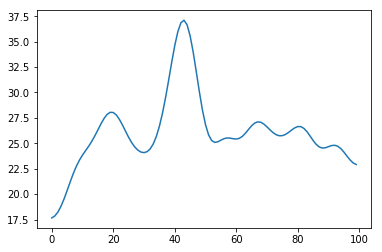

a grad norms [7.022015, 5.639854, 2.8035188, 0.36595878, 5.042593, 1.14930176e-10, 1.507411e-08, 9.8967605e-12, 4.0838294]
aloss -379.6989 closs 18.852205 vloss 71.669044
v grad norms [0.0046262764, 0.003221699, 2.0091266e-08, 0.00020830524]
c grad norms [0.038368262, 0.038361534, 9.1285986e-11, 1.677762e-09, 9.234671e-05]
m grad norms [1.1127065, 1.1632665, 5.862298e-11, 1.2948387e-09, 0.027469542]
 ep,  710  avg frames 26.15
abs action (1,) 0.16278576850891113
max reward 2.0
a grad norms [5.3209047, 4.4600816, 2.8937137, 0.3349624, 3.3594866, 9.7736416e-11, 1.9650386e-09, 7.0523773e-12, 0.8933397]
aloss -369.87302 closs 17.395409 vloss 142.95982
v grad norms [6624.4546, 0.013668473, 1.8885409e-08, 6615.9014]
c grad norms [2.384923, 2.3848488, 1.00664706e-10, 3.001634e-09, 0.00023054557]
m grad norms [6.5506525, 1.9491725, 5.954521e-11, 3.286338e-09, 4.8529587]
 ep,  720  avg frames 28.75
abs action (1,) 0.2016649693250656
max reward 2.0
a grad norms [4.428434, 4.5254245, 2.908295, 0.

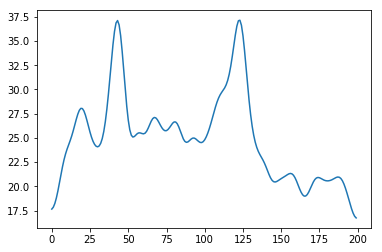

a grad norms [5.329198, 5.2149677, 2.8480198, 0.07496634, 4.735455, 4.3950724e-10, 6.2251175e-08, 1.5849036e-10, 0.16917539]
aloss -402.84534 closs 46.354046 vloss 18.428549
v grad norms [0.00025732687, 0.0002205162, 1.0080217e-08, 2.0438495e-06]
c grad norms [0.030493246, 0.030618498, 2.3784166e-10, 3.0348961e-09, 0.00016608623]
m grad norms [1.5974933, 1.6447867, 7.307342e-11, 6.970181e-10, 0.039907027]
 ep,  810  avg frames 21.1
abs action (1,) 0.8162809014320374
max reward 2.0
a grad norms [25.378738, 8.337764, 3.037675, 4.674756, 4.3714995, 8.8592017e-10, 1.2375988e-07, 5.501802e-11, 23.236692]
aloss -403.9044 closs 28.979733 vloss 96.38284
v grad norms [0.013365355, 0.013925048, 9.295141e-09, 7.825936e-06]
c grad norms [0.02662412, 0.026645685, 2.5707655e-10, 1.3254717e-09, 0.000108344386]
m grad norms [7.6537824, 5.7626534, 7.432441e-11, 1.5065724e-09, 0.19840004]
 ep,  820  avg frames 22.15
abs action (1,) 0.8766074776649475
max reward 2.0
a grad norms [9.679702, 7.6884503, 3.4

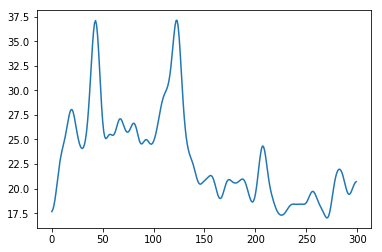

a grad norms [8.50667, 4.410117, 2.4841833, 0.20648876, 3.8128345, 8.0025775e-10, 9.0852524e-08, 1.9678383e-10, 8.151229]
aloss -404.39133 closs 18.57911 vloss 108.666115
v grad norms [0.12137784, 0.12227014, 4.2708814e-09, 2.6798769e-05]
c grad norms [0.059581064, 0.059592277, 3.6179662e-10, 1.4615199e-09, 3.109648e-05]
m grad norms [2.305322, 1.837897, 9.008514e-11, 1.4928713e-09, 0.13537903]
 ep,  910  avg frames 20.85
abs action (1,) 0.907137393951416
max reward 2.0
a grad norms [5.289496, 5.1115394, 2.4223256, 1.3213723, 3.76062, 3.5762823e-10, 5.1829456e-08, 1.4735238e-10, 0.4393989]
aloss -384.3445 closs 22.94383 vloss 18.519066
v grad norms [10.541106, 0.12950775, 3.8853782e-09, 9.515072]
c grad norms [0.98405546, 0.98396385, 3.7942757e-10, 1.4613576e-09, 0.00022583255]
m grad norms [5.2295914, 1.3103197, 9.119554e-11, 8.907998e-10, 3.237768]
 ep,  920  avg frames 21.55
abs action (1,) 0.9820573925971985
max reward 2.0
a grad norms [13.681363, 4.429121, 2.3110814, 0.26395103, 3

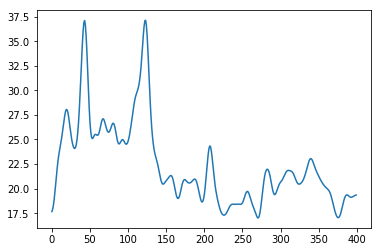

a grad norms [11.792889, 4.130211, 2.1495297, 0.8995696, 3.1261716, 1.1586131e-09, 1.14325566e-07, 2.2214322e-10, 14.2309]
aloss -393.13483 closs 28.910477 vloss 164.95723
v grad norms [0.002584998, 0.002446103, 1.7353341e-09, 6.5980216e-06]
c grad norms [0.014433929, 0.014476279, 5.4740357e-10, 8.4409724e-10, 3.2288164e-05]
m grad norms [1.2631426, 1.2342205, 1.0813203e-10, 8.6873925e-10, 0.0035937042]
 ep,  1010  avg frames 18.6
abs action (1,) 1.230621337890625
max reward 2.0
a grad norms [183.1263, 183.7382, 2.442572, 271.4484, 2.9756377, 1.065558e-09, 1.543252e-07, 2.4554048e-10, 4.4180727]
aloss -388.66425 closs 32.136463 vloss 21.061626
v grad norms [0.0035181104, 0.0035362085, 1.5715216e-09, 5.2094908e-08]
c grad norms [0.008779649, 0.008806973, 5.583541e-10, 8.655531e-10, 1.1685234e-05]
m grad norms [0.95445657, 0.86299133, 1.0955515e-10, 5.811803e-10, 0.0249652]
 ep,  1020  avg frames 17.35
abs action (1,) 1.1618338823318481
max reward 2.0
a grad norms [12.988454, 4.2393, 3.0

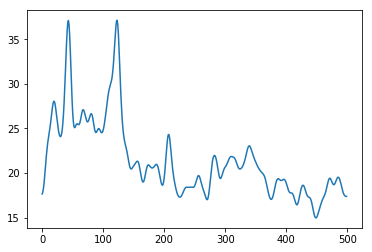

a grad norms [9.319685, 4.5951815, 2.458908, 1.0678406, 3.4138029, 2.4741076e-09, 1.4770463e-07, 6.2300953e-10, 9.016793]
aloss -351.7856 closs 37.0009 vloss 172.7385
v grad norms [0.009540962, 0.008748073, 2.442205e-10, 9.702872e-05]
c grad norms [6.006052, 6.00606, 6.4532363e-10, 1.3292704e-09, 0.00010355114]
m grad norms [1.5409296, 1.5398246, 1.2534618e-10, 7.021686e-10, 0.003576437]
 ep,  1110  avg frames 18.15
abs action (1,) 1.218714714050293
max reward 2.0
a grad norms [18.107494, 3.2933347, 2.5862992, 0.33081138, 2.2213204, 2.3681188e-09, 1.57876e-07, 5.3052696e-10, 31.616919]
aloss -240.60455 closs 29.764664 vloss 45.640934
v grad norms [0.043072328, 0.041415196, 2.4021882e-10, 2.4641724e-05]
c grad norms [0.022692729, 0.02271425, 6.6090794e-10, 2.1157063e-09, 0.00021162143]
m grad norms [0.78314835, 0.7721278, 1.2736986e-10, 5.2931e-10, 0.013279683]
 ep,  1120  avg frames 17.5
abs action (1,) 1.2683513164520264
max reward 2.0
a grad norms [8.809209, 2.9758291, 2.4307384, 0.6

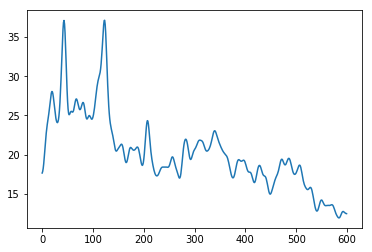

a grad norms [4.4236383, 3.144422, 2.7381442, 0.68680704, 1.6142653, 2.450843e-09, 1.5475825e-07, 3.4915704e-10, 2.6710458]
aloss -261.87268 closs 35.18931 vloss 151.93085
v grad norms [0.35140914, 0.010366697, 2.0501316e-10, 0.2763222]
c grad norms [1.979326, 1.9793829, 7.822772e-10, 1.6536337e-09, 2.9048637e-05]
m grad norms [27.75778, 2.3889158, 1.400876e-10, 2.0781563e-09, 21.140398]
 ep,  1210  avg frames 13.1
abs action (1,) 1.306215763092041
max reward 2.0
a grad norms [4.1091347, 3.5020754, 2.9594343, 1.3282975, 1.3658471, 1.9111162e-09, 1.510229e-07, 5.2358445e-10, 1.0836993]
aloss -255.88391 closs 36.324436 vloss 199.8194
v grad norms [0.115194954, 0.11544984, 1.9689174e-10, 5.993086e-07]
c grad norms [0.013193645, 0.013288703, 7.9322676e-10, 2.5709224e-09, 0.00032409414]
m grad norms [0.8131657, 0.8191736, 1.4139334e-10, 3.689199e-10, 0.00027958397]
 ep,  1220  avg frames 13.75
abs action (1,) 1.2325783967971802
max reward 2.0
a grad norms [5.479602, 3.3200507, 3.1443427, 0.

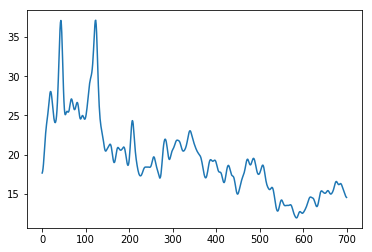

a grad norms [11.808327, 5.443346, 3.5649793, 3.523499, 1.6312467, 2.8974263e-09, 1.2803747e-07, 5.564107e-10, 13.982528]
aloss -183.55324 closs 23.910427 vloss 16.130346
v grad norms [0.07468322, 0.08580276, 9.1096325e-10, 0.00039221687]
c grad norms [0.10361001, 0.103514746, 9.363333e-10, 4.5802904e-09, 0.00054317317]
m grad norms [2.3426504, 2.327084, 1.5777439e-10, 3.976082e-10, 0.001378036]
 ep,  1310  avg frames 14.05
abs action (1,) 1.2921987771987915
max reward 2.0
a grad norms [24.69917, 5.0320196, 3.0801117, 2.4133458, 2.3255048, 2.5322382e-09, 1.8113272e-07, 7.406633e-10, 42.17884]
aloss -238.3056 closs 30.182375 vloss 33.275467
v grad norms [0.07919072, 0.090471864, 8.2183194e-10, 0.00040035415]
c grad norms [0.02425396, 0.023929704, 9.622713e-10, 4.561912e-09, 0.0012591706]
m grad norms [1.5561749, 1.4323785, 1.5895418e-10, 6.251922e-10, 0.031229151]
 ep,  1320  avg frames 14.15
abs action (1,) 1.3781622648239136
max reward 2.0
a grad norms [25.425827, 3.5332043, 3.221931,

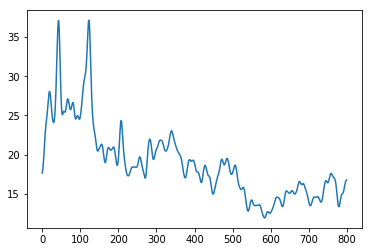

a grad norms [19.386, 3.94698, 4.2851605, 0.958288, 1.453135, 3.0278942e-09, 1.5762826e-08, 3.0027444e-10, 34.51747]
aloss -208.1279 closs 17.344564 vloss 105.79846
v grad norms [565.8367, 0.20857328, 1.2610796e-09, 550.5511]
c grad norms [27.074547, 27.074593, 1.1838824e-09, 3.516996e-09, 3.110654e-05]
m grad norms [1.6170875, 1.8799431, 1.7453514e-10, 1.0574186e-09, 0.07600815]
 ep,  1410  avg frames 16.65
abs action (1,) 1.3043632507324219
max reward 2.0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-3a5e43a1bc98>", line 148, in <module>
    train(actor = True, value = True, n_steps = 1)
  File "<ipython-input-13-df426830a9de>", line 33, in train
    aloss, a_grad_norms = train_actor(self, feed_dict, printon = itr == 0)
  File "<ipython-input-12-32056d0a86db>", line 8, in train_actor
    a_grad_norms = self.sess.run(self.a_grads, feed_dict)
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 900, in run
    run_metadata_ptr)
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1135, in _run
    feed_dict_tensor, options, run_metadata)
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1316, in _do_run
    run_metad

KeyboardInterrupt: 

In [14]:
if trained:
    try:
        saver.restore(sess, tffile)
        with open(obj_fname, "rb") as f:
            ah, sh, shraw, rh, rdecayedh, maskh, ep, globalframes, isexploit = pickle.load(f)
        print('restored from save file')
    except:
        print('no save file detected')
        trained = 0
MAX_SEQ_LEN = 5000
for ep in range(ep, 10000000):
    if ep % 100 == 0 and trained and ep > 0:
        save_path = saver.save(sess, tffile)
        print('saved at epoch', ep)
        with open(obj_fname,"wb") as f:
            pickle.dump(
                [ah[-NUM_KEEP:], sh[-NUM_KEEP:], shraw[-NUM_KEEP:],
                 rh[-NUM_KEEP:], rdecayedh[-NUM_KEEP:], maskh[-NUM_KEEP:], ep, globalframes, isexploit[-NUM_KEEP:]
                ], f)
    trained = 1
    ongoing = 1
    
    an, sn, snraw, rn, rdecayedn, maskn = [
        np.zeros((0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
    frame = 0
    score = 0
    restart_delay = 5
    obs = env.reset()
    obsraw = obs
    snraw = np.concatenate((snraw, obs.reshape(1, -1)), 0)
    obs = np.concatenate((obs, np.zeros(N_ACT)))
    obs = np.concatenate((obs, np.zeros_like(obs)))
    obs_mat = np.concatenate((
        obs[None,:],np.zeros((NUM_HISTORY-1, N_STATE))), 0)
    rn = [0]
    done_ctr = 0
    sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
    step_num = 0
    step_shifted = -1
    show_shift = 0
    if ep <= INIT_LEN:
        exploit = 0
    else:
        exploit = 1
    if np.random.rand() > .5:
        prob_random = PERCENT_CHOOSE_OPTIMAL#2#.95#1 - 1/np.sqrt(ep+1)
    else:
        prob_random = 2
    while 1:
        step_num += 1
        a = pi.act(obs_mat.flatten())
        if not exploit:
            a = np.random.randn(*a.shape)
        an = np.concatenate((an, a[None,:]), 0)
        snraw = np.concatenate((snraw, obsraw[None,:]), 0)
        last_obs = obs
#         last_obsraw = obsraw
        obs, r, done, _ = env.step(a)
        obsraw = obs
        r = r + 1 * REWARD_MULT

        obs_mat = accumulate_state(
            obs, a, obs_mat, STATE_DECAY, style = 'np')
        
        rn.append(r)
        sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
        score += r
        frame += 1
        if ep > INIT_LEN:
            still_open = env.render("human")
        else:
            still_open = 1
        if done:
            done_ctr += 1
            if done_ctr > 3:
                if ep % MAX_SEQ_LEN == 0:
                    print('score', score, ' frames', frame)
                break
        if still_open==False:
            crashhere
        if not done: continue
        if restart_delay==0:
            print("score=%0.2f in %i frames" % (score, frame))
            if still_open!=True:      # not True in multiplayer or non-Roboschool 
                break
            restart_delay = 2000*2  # 2 sec at 60 fps
        restart_delay -= 1
        if restart_delay==0: 
            break
    a = pi.act(obs_mat.flatten())
    an = np.concatenate((an, a[None,:]), 0)
    localframes.append(frame)
    rn = np.array(rn)
    rn[-1] = rn[-1] - 20 * REWARD_MULT
    rewards = [0]
    for ir in rn[::-1]:
        rewards.append(rewards[-1] * GAMMA + ir)
    rdecayedn = np.array(rewards)[:0:-1]
    lenrdec = len(rdecayedn)
#     rdecayedn = rdecayedn + lenrdec
#     rdecayedn = rdecayedn - np.arange(lenrdec) * 1.8
    maskn = np.ones_like(rn)
    if step_shifted > -1:
        if step_shifted == 0:
            raise ValueError('step shifted not allowed 0')
        maskn[:step_shifted - 1] = 0
    if ep == 0:
        ah, sh, shraw, rh, rdecayedh, maskh = [
            np.expand_dims(v, 0) for v in [an, sn, snraw, rn,rdecayedn, maskn]]
        isexploit = [exploit]
    else:
        def get_updated_h(h, n, third_dim):
            hshape = h.shape[1]
            nshape = n.shape[0]
            if third_dim:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape, n.shape[-1]))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((
                        h.shape[0], nshape - hshape, h.shape[-1]))), 1)
            else:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((h.shape[0], nshape - hshape))), 1)
            h = np.concatenate((h, np.expand_dims(n, 0)), 0)
            return h
            
        ah, sh, shraw = [get_updated_h(h, n, 1) for  h, n in zip(
            [ah, sh, shraw], [an, sn, snraw])]
        
        rh, rdecayedh, maskh = [
            get_updated_h(h, n, 0) for h, n in zip(
                [rh, rdecayedh, maskh], [rn, rdecayedn, maskn])]
        isexploit.append(exploit)
    if ep % 1 == 0 and ep > INIT_LEN:
        ah, sh, shraw, rh,rdecayedh, maskh, isexploit = [
            v[-NUM_KEEP:] for v in [ah, sh, shraw, rh,rdecayedh, maskh, isexploit]]
        globalframes.append(np.mean(localframes))
        localframes = []
        batch_size = 16
        if ep < batch_size:
            batch_size = ep
        num_hist = ah.shape[0]
        if ep == INIT_LEN + 1:
            train(actor = False, n_steps = N_PRETRAIN, forced_hist=0)
            #train(value = False, n_steps = 20, forced_hist=0)
        train(actor = True, value = True, n_steps = 1)


In [ ]:
probability.shape

In [ ]:
np.random.choice(num_hist - forced_hist, batch_size - forced_hist,replace=False, p=probability)

In [ ]:
self.areg + self.aregmeanbyaction + self.actstdpenalty + self.a_mse

In [ ]:
sess.run(self.a_loss_raw, feed_dict)

In [ ]:
self.a_loss_raw + self.aregtotal

In [ ]:
sess.run(self.model_estimator.output[:,:-1], feed_dict).shape

In [ ]:
sess.run(self.statesraw_expanded[:,1:], feed_dict).shape

In [ ]:
sess.run(self.maskexpanded[:,:-1], feed_dict).shape

In [ ]:

        self.v_loss_raw = tf.reduce_mean(tf.square(
            self.returnsdecayed - self.state_value_estimate) * self.mask * self.is_exploit2d)
        self.v_loss =  self.v_loss_raw + self.vreg
        
        self.m_loss_raw = tf.reduce_mean(tf.square(
            self.model_estimator.output[:,:-1] - self.statesraw_expanded[:,1:]
        ) * self.maskexpanded[:,:-1]) * 100
        self.m_loss = self.m_loss_raw + self.mreg
        
        self.c_loss_raw = tf.reduce_mean(tf.square(
            self.advantage_estimate[:,:-1] - self.advantage) * self.mask[:,:-1])
        self.c_loss =  self.c_loss_raw + self.creg
        

In [ ]:
ah[-1][10]

In [ ]:

            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.a_loss_critic,self.a_loss_model,
                self.a_loss_secondaction,
                self.areg, self.aregmeanbyaction, self.actstdpenalty
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.creg, self.grad_norm_c, self.grad_c_1

            ]]
            self.m_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.m_loss_minimize, self.m_loss_raw, 
                self.mreg, self.grad_norm_m, self.grad_m_1
            ]]
        

In [ ]:
actions.shape

In [ ]:
returns.shape, statesraw.shape, returnsdecayed.shape, mask.shape, \
    states.reshape(*states.shape[:2], N_HISTORY, N_STATE).shape

In [ ]:
self.sess.run(self.actions, feed_dict).shape

In [ ]:
self.sess.run(self.obs, feed_dict).shape

In [ ]:
self.sess.run(self.a_loss_secondaction, feed_dict).shape

In [ ]:
self.sess.run(self.future_actions, feed_dict).shape

In [ ]:
self.sess.run(self.maskexpanded, feed_dict).shape

In [ ]:

                        self.returns:returns,
                        self.statesraw: statesraw,
                        self.returnsdecayed:returnsdecayed,
                        self.lr: .01 / np.power(ep + 20, .4),
                        self.mask:mask,
                        self.obs_raw: states.reshape(*states.shape[:2], N_HISTORY, N_STATE)

In [ ]:
states.shape

In [ ]:
self.obs_raw

In [ ]:
a.shape, obs.shape, obs_mat.shape